<a href="https://colab.research.google.com/github/MatiasSiles/Sales-Optimization/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we aim to optimize sales for a fictitious business using machine learning techniques. By leveraging historical customer and transaction data, we build and evaluate various regression models to predict key metrics such as profit, total spent, and customer lifetime value. The goal is to identify patterns and factors that drive higher sales, enabling data-driven decision-making to improve marketing strategies, customer retention, and overall business performance

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from utils2 import *

In [185]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(42)

# EDA for training models

In [186]:
# Data upload
df = pd.read_csv('/content/Sales_Business_Testing.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)

In [187]:
# Basic info of the dataset
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB") # converts actual memory usage from bytes to megabytes
print("\nFirst 5 rows:")
print(df.head())

print("\nData types:")
print(df.dtypes.value_counts())

print("\nMissing values:")
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

Dataset shape: (10000, 92)
Memory usage: 7.02 MB

First 5 rows:
   Unnamed: 0  customer_age  unit_price  quantity  discount_rate  \
0           0            56      350.94         8           0.18   
1           1            69      472.66         2           0.26   
2           2            46      497.80         2           0.12   
3           3            32      230.64         3           0.08   
4           4            60      133.74         3           0.15   

   profit_margin  subtotal  discount_amount  tax_rate  tax_amount  ...  \
0           0.49   2807.52           500.26       0.1      280.75  ...   
1           0.45    945.32           247.76       0.1       94.53  ...   
2           0.14    995.60           122.48       0.1       99.56  ...   
3           0.27    691.91            55.90       0.1       69.19  ...   
4           0.47    401.22            59.19       0.1       40.12  ...   

   region_target_encoded  sales_rep_target_encoded  \
0                 566.29    

       Unnamed: 0  customer_age  unit_price  quantity  discount_rate  \
count    10000.00       10000.0    10000.00  10000.00       10000.00   
mean      4999.50          48.8      255.25      4.99           0.15   
std       2886.90          17.9      141.27      2.57           0.09   
min          0.00          18.0       10.06      1.00           0.00   
25%       2499.75          34.0      135.06      3.00           0.08   
50%       4999.50          49.0      256.20      5.00           0.15   
75%       7499.25          64.0      375.93      7.00           0.23   
max       9999.00          79.0      499.95      9.00           0.30   

       profit_margin  subtotal  discount_amount  tax_rate  tax_amount  ...  \
count       10000.00  10000.00         10000.00   10000.0    10000.00  ...   
mean            0.30   1274.94           192.29       0.1      127.49  ...   
std             0.12   1028.76           209.57       0.0      102.88  ...   
min             0.10     10.06         

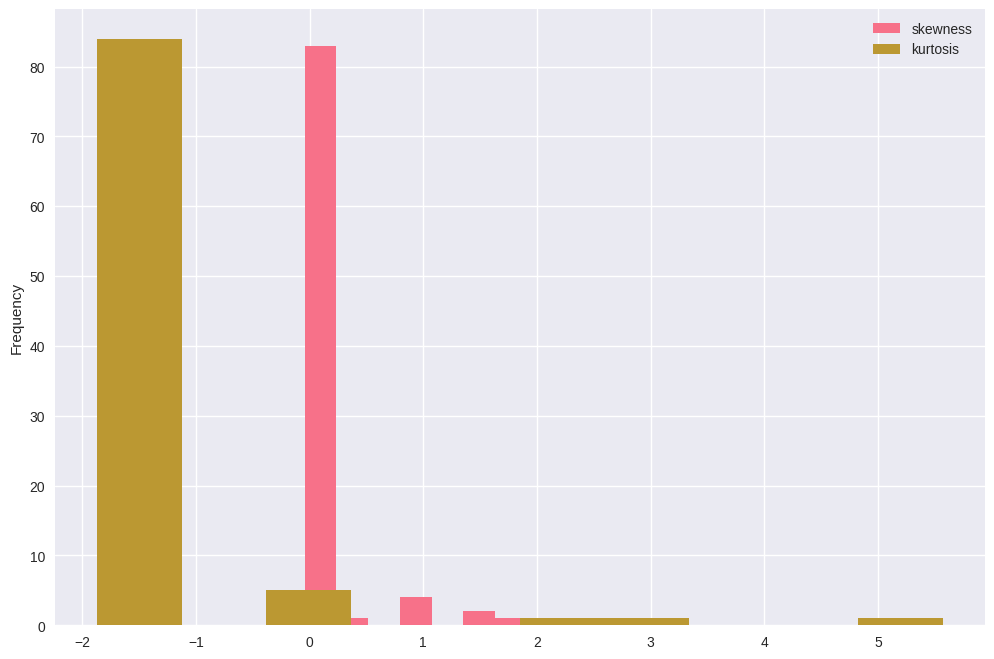

In [188]:
# Data analysis
analyzer = StatisticalAnalyzer()
descriptive_stats = analyzer.descriptive_statistics(df)

print(descriptive_stats['numeric_summary'].round(2))

# CATEGORICAL VARIABLES SUMMARY, in this case, there isn't categorical variables, because this testing datast don't have
# for col, stats in descriptive_stats['categorical_summary'].items():
#     print(f"\n{col}:")
#     print(f"  Unique values: {stats['unique_values']}")
#     print(f"  Mode: {stats['mode']}")
#     print("  Top 5 values:")
#     print(stats['value_counts'].head())

# Distribution analysis
print()
descriptive_stats['skewness'].plot(kind='hist', label='skewness')
descriptive_stats['kurtosis'].plot(kind='hist', label='kurtosis')
plt.legend()
plt.show()

i decided to do this because i think that can exist hidden relationships in important features for the training mode. If exist that relationship, probably can improve the model's performance. Whether a difference or relationship in the data is real or just a matter of luck

Significance:
*   p < 0.05 → is significant: probably is real the relationship
*   p > 0.05 → is not significant


High correlations found (>0.7):
          Feature1         Feature2  Correlation
0         subtotal  discount_amount     0.739431
1         subtotal       tax_amount     1.000000
2         subtotal     total_amount     0.989647
3         subtotal           profit     0.843291
4  discount_amount       tax_amount     0.739431
5       tax_amount     total_amount     0.989647
6       tax_amount           profit     0.843291
7     total_amount           profit     0.851825


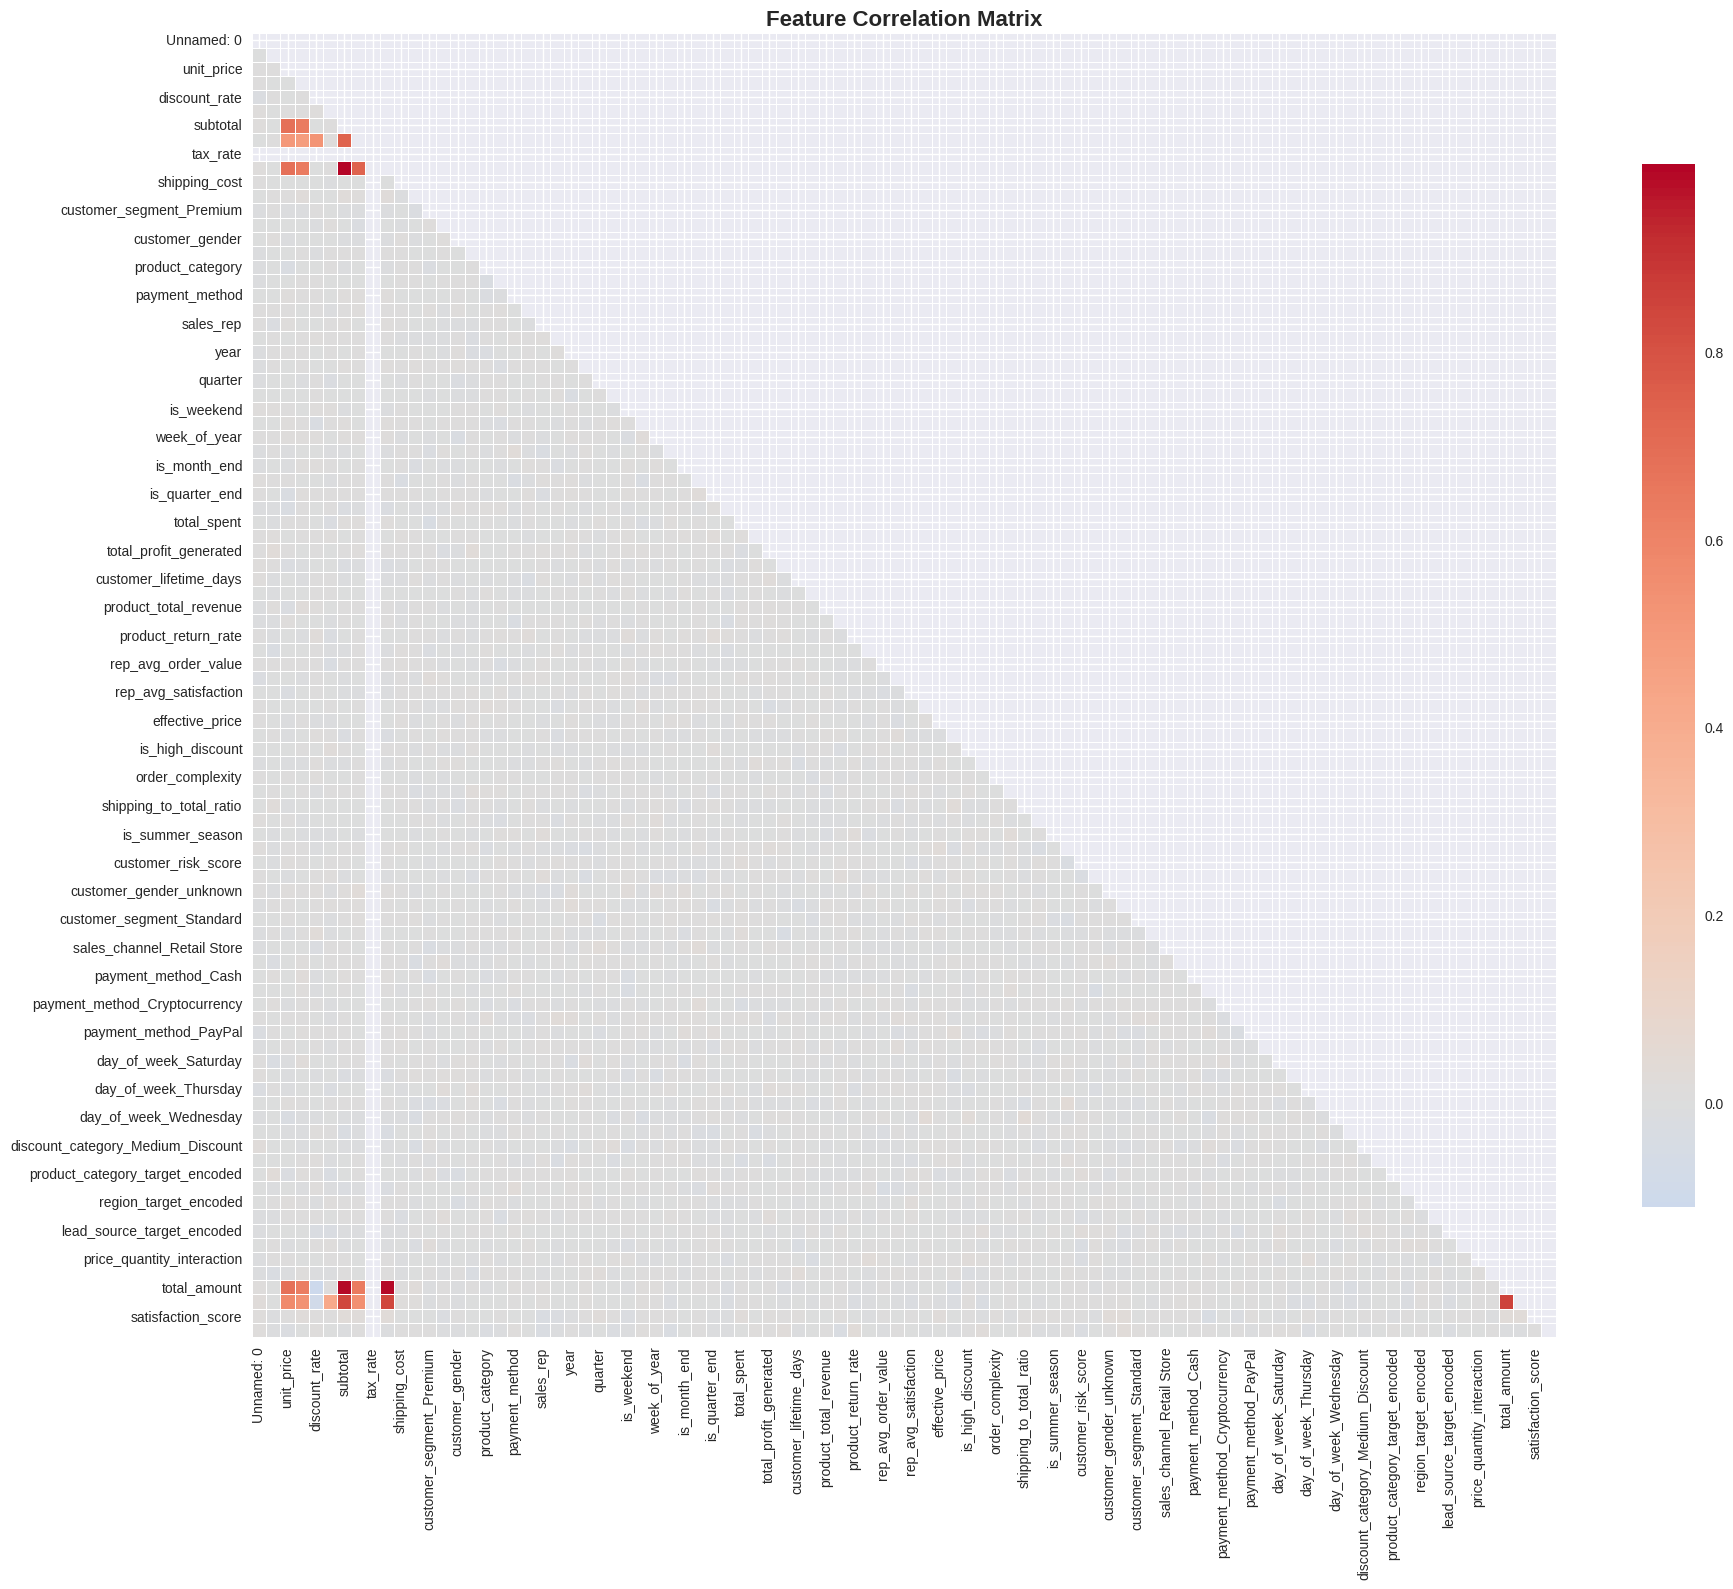


total_amount - Top 10 correlations:
total_amount                      1.000000
subtotal                          0.989647
tax_amount                        0.989647
profit                            0.851825
unit_price                        0.679854
discount_amount                   0.635556
quantity                          0.630042
discount_rate                     0.110911
discount_category_Low_Discount    0.024250
satisfaction_score                0.023979
Name: total_amount, dtype: float64

profit - Top 10 correlations:
profit                1.000000
total_amount          0.851825
tax_amount            0.843291
subtotal              0.843291
unit_price            0.577967
discount_amount       0.543101
quantity              0.535175
profit_margin         0.417419
discount_rate         0.090147
satisfaction_score    0.025564
Name: profit, dtype: float64

satisfaction_score - Top 10 correlations:
satisfaction_score             1.000000
customer_segment_Enterprise    0.029295
payme

In [189]:
corr_matrix = analyzer.correlation_analysis(df, method='pearson')

# Find highly correlated features, this algorithm goes through the entire dataset by rows, comparing it with the threshold
def find_high_correlations(corr_matrix, threshold=0.8):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)): # 91 columns
        for j in range(i+1, len(corr_matrix.columns)): # It is a loop where each iteration goes through all the columns while subtracting 1 column until reaching 0 columns
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Feature1': corr_matrix.columns[i], # add column 1 which participates in high correlations
                    'Feature2': corr_matrix.columns[j], # add column 2 which participates in high correlations
                    'Correlation': corr_matrix.iloc[i, j] # add the value
                })
    return pd.DataFrame(high_corr_pairs)

high_corr = find_high_correlations(corr_matrix, threshold=0.7)

if not high_corr.empty: # check whether or not high correlations were found
    print(f"\nHigh correlations found (>0.7):")
    print(high_corr)
else:
    print("\nNo high correlations found (>0.7)")

# Visualize correlation matrix, It's a confusing graph but I modified it to only show the correlations.
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # only shows half of the heat map
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Target variable correlations
TARGET_VARIABLES = ['total_amount', 'profit', 'satisfaction_score','is_returned', 'order_frequency', 'customer_lifetime_days']

for target in TARGET_VARIABLES:
    if target in df.columns:
        target_corr = corr_matrix[target].abs().sort_values(ascending=False) # find the 10 best correlations for each target
        print(f"\n{target} - Top 10 correlations:")
        print(target_corr.head(10))

In [190]:
# It looks for relationships between numerical and categorical variables
# categorical_cols = ['customer_gender', 'customer_segment', 'sales_channel', 'payment_method']
# numerical_targets = ['total_amount', 'profit', 'satisfaction_score']

# hypothesis_results = {}

# for cat_col in categorical_cols:
#     if cat_col in df.columns:
#         for num_col in numerical_targets:
#             if num_col in df.columns:
#                 print(f"\nTesting {cat_col} vs {num_col}:")

#                 test_result = analyzer.hypothesis_testing(
#                     df, cat_col, num_col, test_type='auto'
#                 )

#                 hypothesis_results[f"{cat_col}_vs_{num_col}"] = test_result

#                 print(f"  Test used: {test_result['test_used']}")
#                 print(f"  P-value: {test_result['p_value']:.6f}")
#                 print(f"  Significant: {'Yes' if test_result['significant'] else 'No'}")

time series analysis

Analyzing sales over time...
Time series statistics:
  Mean: $206287.89
  Std: $19117.66
  Autocorrelation (lag=1): -0.010


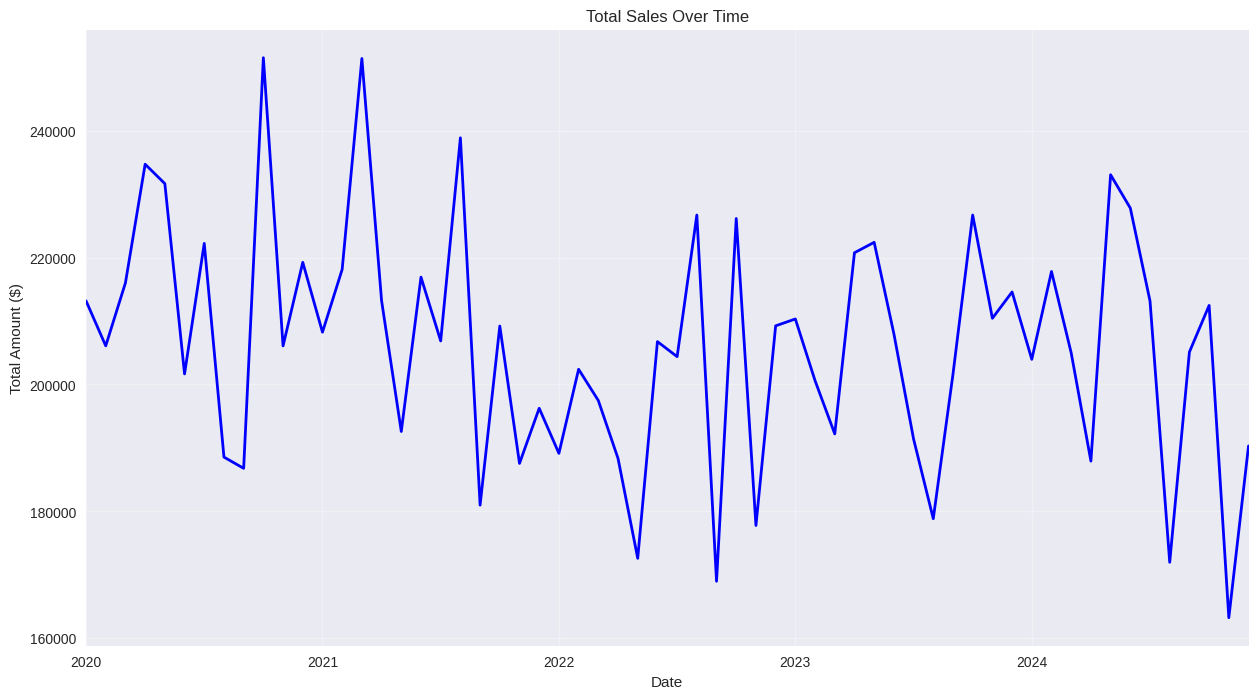

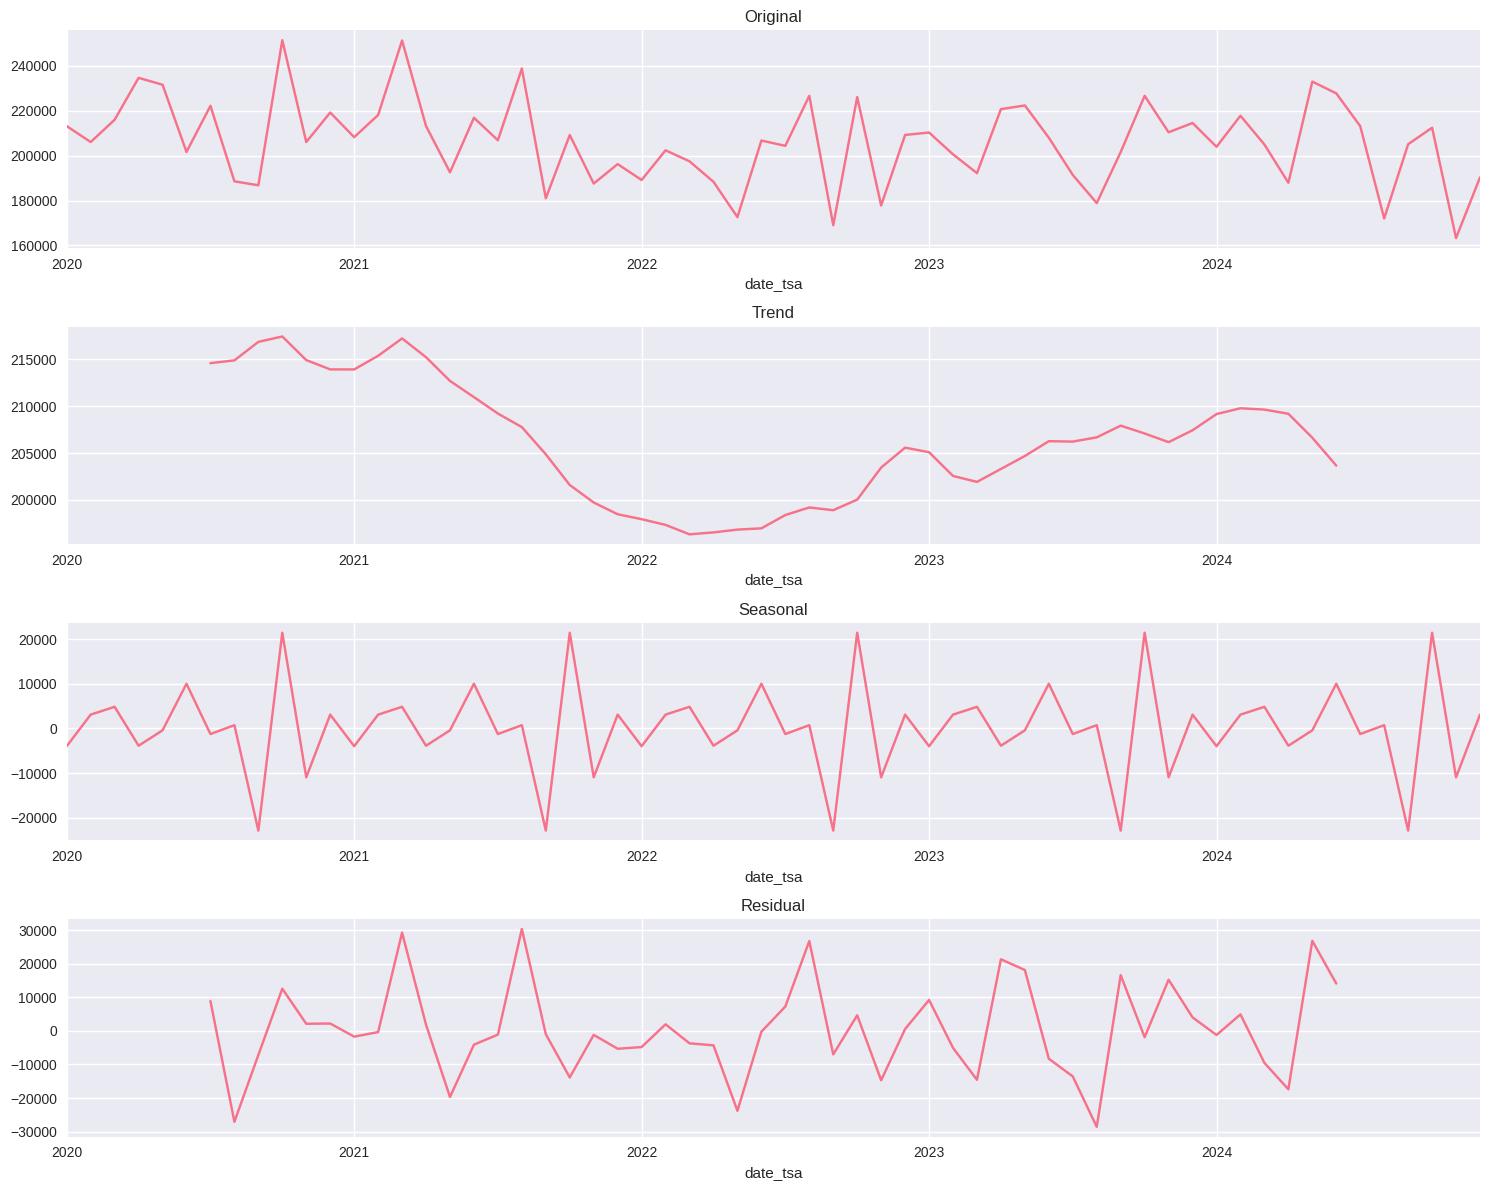

In [191]:
df['year'] = np.random.randint(2020, 2025, size=10000)
df['month'] = np.random.randint(1, 13, size=10000)

# Create a date column for time series analysis
if 'year' in df.columns and 'month' in df.columns:
    df['date_tsa'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

    # Perform time series analysis on total_amount
    if 'total_amount' in df.columns:
        print("Analyzing sales over time...")

        ts_results = analyzer.time_series_analysis(
            df, 'date_tsa', 'total_amount', freq='M'
        )

        print(f"Time series statistics:")
        print(f"  Mean: ${ts_results['mean']:.2f}")
        print(f"  Std: ${ts_results['std']:.2f}")
        if ts_results['autocorrelation']:
            print(f"  Autocorrelation (lag=1): {ts_results['autocorrelation']:.3f}")

        # Plot time series
        plt.figure(figsize=(15, 8))
        ts_results['original_series'].plot(title='Total Sales Over Time',
                                         color='blue', linewidth=2)
        plt.xlabel('Date')
        plt.ylabel('Total Amount ($)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot decomposition if available
        if 'decomposition' in ts_results:
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            ts_results['original_series'].plot(ax=axes[0], title='Original')
            ts_results['trend'].plot(ax=axes[1], title='Trend')
            ts_results['seasonal'].plot(ax=axes[2], title='Seasonal')
            ts_results['residual'].plot(ax=axes[3], title='Residual')
            plt.tight_layout()
            plt.show()

#Customer Segmentation Kmeans

Why i choose these targets?:

*   total_amount: The aim is to predict the business's sales taking into account the variables that influence them, such as quantity sold, discounts prices, dates, etc
*   profit: anticipate profits, to know which products are profitable, improve decision-making and optimize prices.
*   satisfaction_score: Reduce churn, recommend products to each type ofcustomer, improve customer experience
*   is_returned: reduce returns, optimize inventory, improve quality and products
*   order_frequency: customer retention, detect loyal customers, personalize marketing, improve cash flow
*   customer_lifetime_days: Seeking to ensure that customers remain active in the business for longer periods of time

In [192]:
# Initialize the segmenter
segmenter = CustomerSegmenter()

# Prepare data for segmentation
segmentation_features = ['total_spent', 'avg_order_value', 'order_frequency',
                        'customer_lifetime_days', 'satisfaction_score']

# Check which features are available
available_features = [f for f in segmentation_features if f in df.columns]
available_features

['total_spent',
 'avg_order_value',
 'order_frequency',
 'customer_lifetime_days',
 'satisfaction_score']

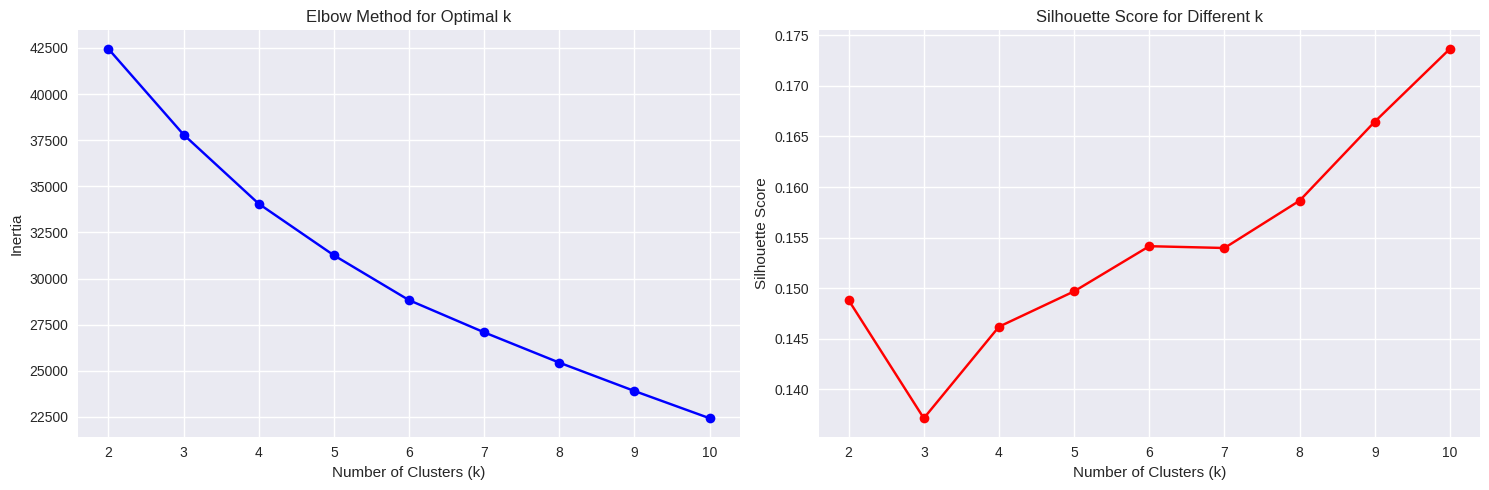


Optimal number of clusters: 10
Best silhouette score: 0.174


In [193]:
# Find Optimal Number of Clusters

if len(available_features) >= 3:
    # Find optimal clusters
    clustering_data = df[available_features].fillna(0)
    optimal_clusters = segmenter.find_optimal_clusters(clustering_data, max_clusters=10)

    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow curve
    ax1.plot(optimal_clusters['k_values'], optimal_clusters['inertias'], 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.grid(True)

    # Silhouette scores
    ax2.plot(optimal_clusters['k_values'], optimal_clusters['silhouette_scores'], 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score for Different k')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find best k based on silhouette score
    best_k_idx = np.argmax(optimal_clusters['silhouette_scores'])
    best_k = optimal_clusters['k_values'][best_k_idx]
    best_silhouette = optimal_clusters['silhouette_scores'][best_k_idx]

    print(f"\nOptimal number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette:.3f}")
else:
    print("Not enough features for clustering analysis")

🎯 PERFORMING RFM ANALYSIS
Segment distribution:
segments
Potential Loyalists    2747
About to Sleep         1917
Lost                   1697
Loyal Customers         952
Promising               932
Champions               652
New Customers           613
Hibernating             490
Name: count, dtype: int64


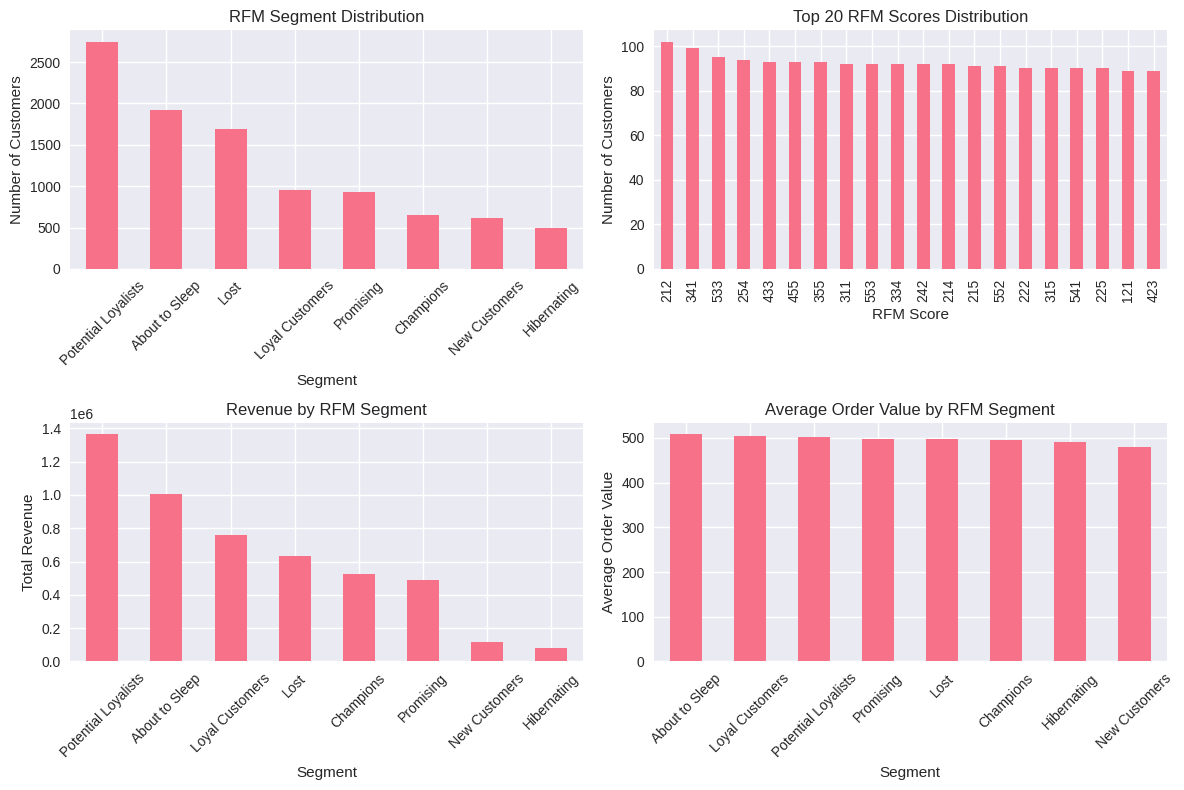

In [194]:
print("🎯 PERFORMING RFM ANALYSIS")
print("=" * 50)

# Perform RFM analysis
rfm_segments = segmenter.rfm_segmentation(df)

print(f"Segment distribution:")
segment_counts = rfm_segments['segments'].value_counts()
print(segment_counts)

# Add RFM results to dataframe
df['rfm_segment'] = rfm_segments['segments']
df['rfm_score'] = rfm_segments['rfm_combined']

# Visualize RFM segments
plt.figure(figsize=(12, 8))

# RFM Segment distribution
plt.subplot(2, 2, 1)
segment_counts.plot(kind='bar')
plt.title('RFM Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# RFM scores distribution
plt.subplot(2, 2, 2)
df['rfm_score'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 RFM Scores Distribution')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')

# Revenue by segment
plt.subplot(2, 2, 3)
revenue_by_segment = df.groupby('rfm_segment')['total_spent'].sum().sort_values(ascending=False)
revenue_by_segment.plot(kind='bar')
plt.title('Revenue by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

# Average order value by segment
plt.subplot(2, 2, 4)
avg_order_by_segment = df.groupby('rfm_segment')['avg_order_value'].mean().sort_values(ascending=False)
avg_order_by_segment.plot(kind='bar')
plt.title('Average Order Value by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [195]:
if len(available_features) >= 3:
    # Perform K-means clustering

    clustering_data = df[available_features].fillna(0)
    kmeans_result = segmenter.kmeans_segmentation(clustering_data, n_clusters=5)

    print(f"Cluster distribution:")
    cluster_counts = pd.Series(kmeans_result['labels']).value_counts().sort_index()
    print(cluster_counts)

    print(f"Silhouette Score: {kmeans_result['silhouette_score']:.3f}")
    print(f"Inertia: {kmeans_result['inertia']:.2f}")

    # Add cluster labels to dataframe
    df['cluster'] = kmeans_result['labels']

    # Display cluster centers
    print("\nCluster Centers:")
    centers_df = pd.DataFrame(kmeans_result['centers'], columns=available_features)
    centers_df.index = [f'Cluster {i}' for i in range(len(centers_df))]
    print(centers_df.round(2))

else:
    print("Not enough features for K-means clustering")

Cluster distribution:
0    1941
1    2024
2    2074
3    2026
4    1935
Name: count, dtype: int64
Silhouette Score: 0.150
Inertia: 31260.59

Cluster Centers:
           total_spent  avg_order_value  order_frequency  \
Cluster 0       729.43           680.97           239.63   
Cluster 1       702.17           285.62           671.08   
Cluster 2       330.73           264.53           343.28   
Cluster 3       221.71           610.22           513.53   
Cluster 4       518.83           677.47           752.91   

           customer_lifetime_days  satisfaction_score  
Cluster 0                  178.27                3.25  
Cluster 1                  114.15                2.80  
Cluster 2                  259.30                2.86  
Cluster 3                   91.03                2.93  
Cluster 4                  272.15                3.20  


# Visualize Clustering Results

The dataset I'm using is complex, which is why the groups cannot be observed well.

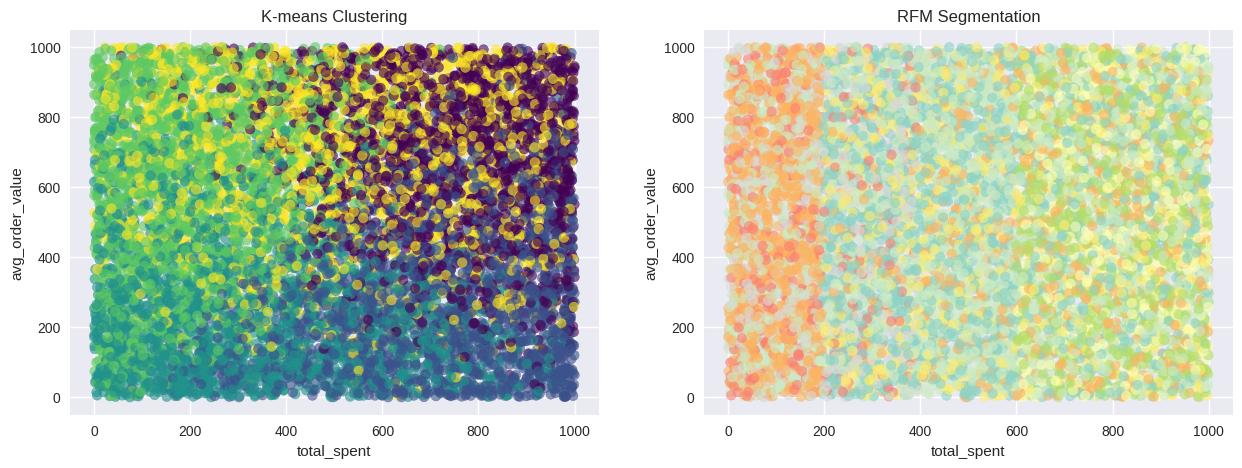

In [196]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.ravel()
axes[0].scatter(df[available_features[0]], df[available_features[1]],
                      c=df['cluster'], cmap='viridis', alpha=0.6)
axes[0].set_xlabel(available_features[0])
axes[0].set_ylabel(available_features[1])
axes[0].set_title('K-means Clustering')

rfm_numeric = pd.Categorical(df['rfm_segment']).codes
axes[1].scatter(df[available_features[0]], df[available_features[1]],
                      c=rfm_numeric, cmap='Set3', alpha=0.6)
axes[1].set_xlabel(available_features[0])
axes[1].set_ylabel(available_features[1])
axes[1].set_title('RFM Segmentation')

plt.show()

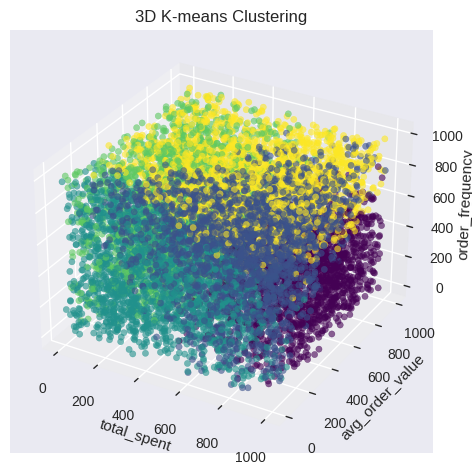

In [197]:
ax = plt.subplot(1, 2, 2, projection='3d')
scatter3d = ax.scatter(df[available_features[0]], df[available_features[1]],
                      df[available_features[2]], c=df['cluster'], cmap='viridis', alpha=0.6)
ax.set_xlabel(available_features[0])
ax.set_ylabel(available_features[1])
ax.set_zlabel(available_features[2])
ax.set_title('3D K-means Clustering')
plt.show()

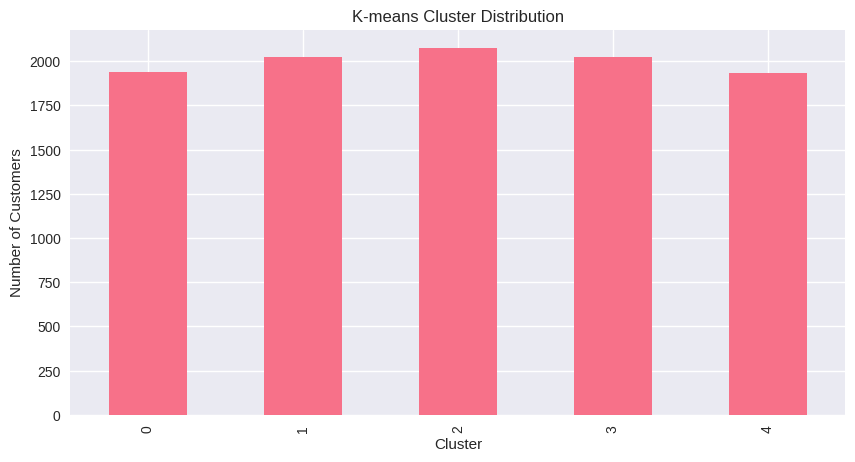

In [198]:
# Cluster distribution
cluster_counts.plot(kind='bar', figsize=(10,5))
plt.title('K-means Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

The target variables do not show linearity, which is why the clustering was not perfect.

Text(0.5, 1.0, 'Feature Correlation Matrix')

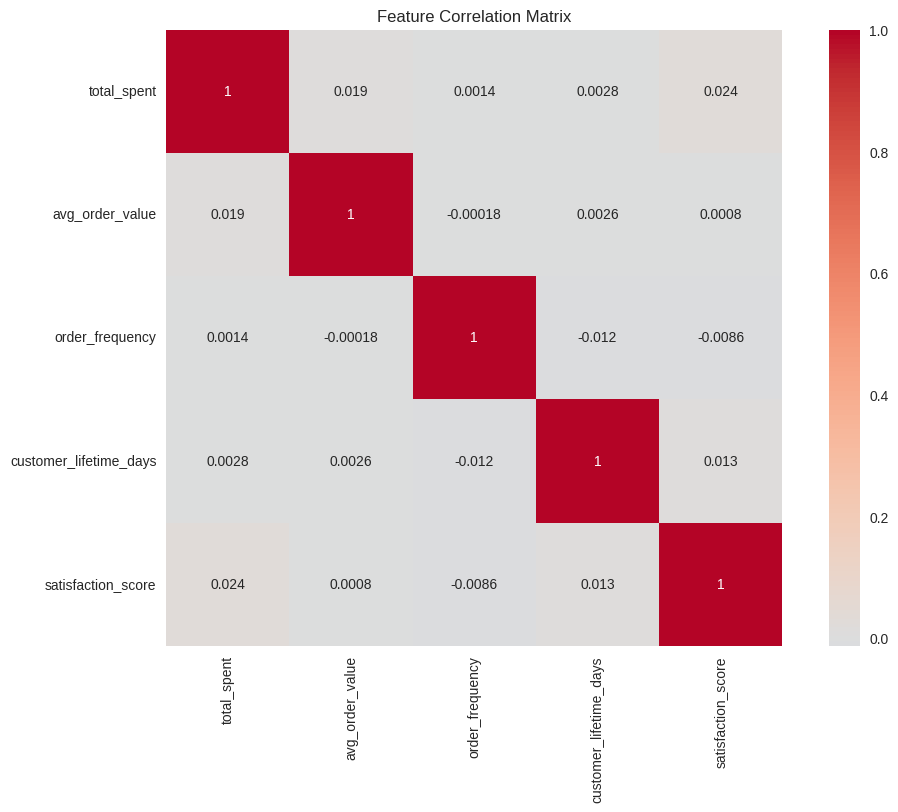

In [199]:
# Feature correlation heatmap
correlation_matrix = df[available_features].corr()
sns.heatmap(correlation_matrix, annot=True, square=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

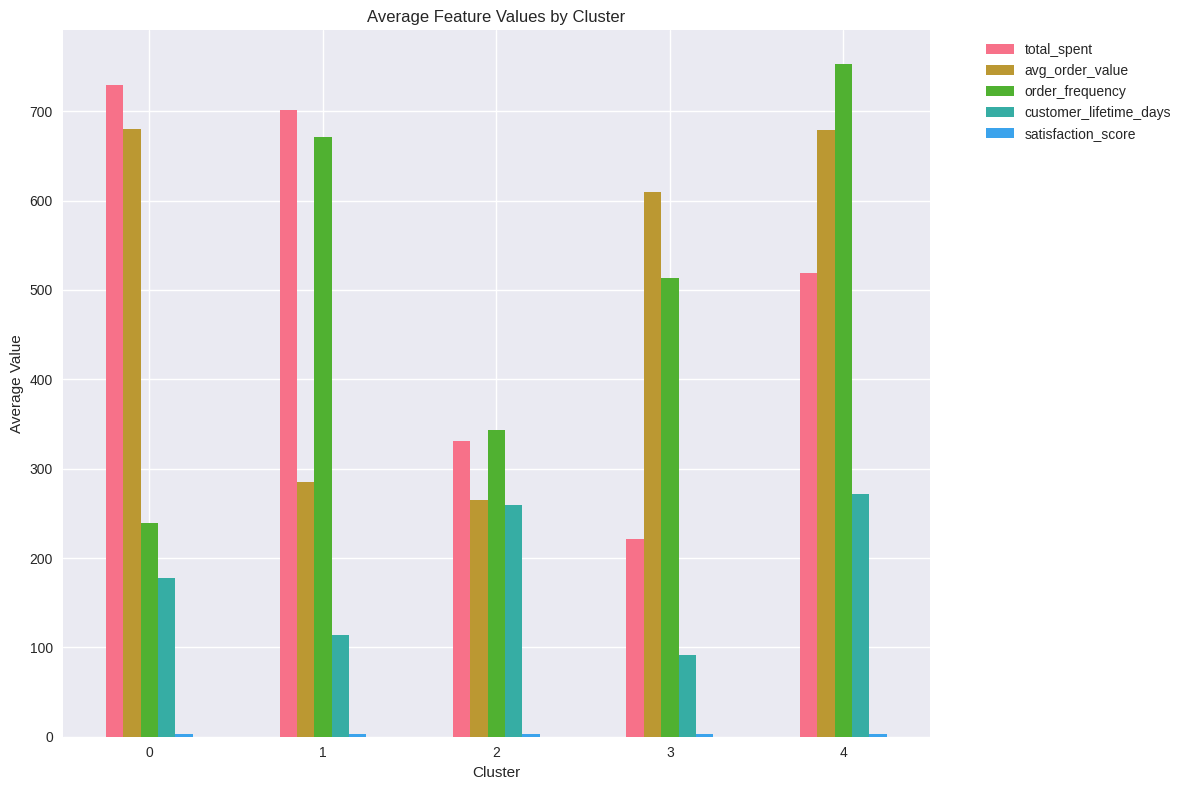

In [200]:
# Cluster characteristics
cluster_means = df.groupby('cluster')[available_features].mean()
cluster_means.plot(kind='bar')
plt.title('Average Feature Values by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Regression Models

In [201]:
# # Initialize ML optimizer
# ml_optimizer = MachineLearningOptimizer()

# # Train regression models for each numerical target
# regression_targets = ['total_amount', 'profit', 'satisfaction_score'] # i choose only 3 targets because is very heavy to train

# regression_results = {}

# for target in regression_targets:
#     if target in df.columns:

#         # Prepare data
#         for col in df:
#           if df[col].dtype == "datetime64[ns]":
#              df.drop(col, inplace=True, axis=1)

#         X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
#             df, target, test_size=0.2, random_state=42
#         )

#         # Train regression models
#         results = ml_optimizer.train_regression_models(X_train, y_train, X_test, y_test)
#         regression_results[target] = results

#         # Display results
#         print(f"\nModel Performance for {target}:")
#         for model_name, metrics in results.items():
#             # if 'error' not in metrics:
#             print(f"{model_name}:")
#             print(f"Test R²: {metrics['test_r2']:.4f}")
#             print(f"Test MSE: {metrics['test_mse']:.4f}")

# print(f"Train set shape: {X_train.shape}")
# print(f"Test set shape: {X_test.shape}")

The metrics are good, there is no need to optimize parameters.